### Filter the Reichart adata provided

The adata is very large, but the majority of the non-diseased samples are not from this study, but other studies such as the Teichman ones. Therefore, we should filter this adata to a smaller one that just includes the 6 new, non-diseased samples.

#### Reichart et al. 2022 (Seidman Lab)

1. Technology: 10x 3' v3
2. Cell vs. nuclei: Nuclei only
3. Regions: 'LV': 219149, 'RV': 63223

Characterized 880,000 nuclei from 18 control and 61 failing, nonischemic human hearts with pathogenic variants in DCM and ACM genes or idiopathic disease. However, 12 of the controls are from the Litvinukova study, so there are only 6 additional samples from this dataset.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from collections import Counter
import re
import gc
import scanpy.external as sce

In [2]:
def convert_age_string_to_decade(age_string):
    # Extract decade number using regular expression
    
    mapping = {
        'infant stage': '0-9',
        'child stage': '0-9',
        'adolescent stage': '10-19',
        'young adult stage': '20-29',
        'third decade human stage': '30-39',
        'fourth decade human stage': '40-49',
        'fifth decade human stage': '50-59',
        'sixth decade human stage': '60-69',
        'seventh decade human stage': '70-79',
        'eighth decade human stage': '80-89'   
    }

    # Get the decade range for the provided age string
    decade = mapping.get(age_string, None)  # Returns None if age_string not found in mapping
    
    return decade

In [3]:
def age_convertor(input_string):
    # Split the input string by '-'
    parts = input_string.split('-')

    # Convert parts to integers
    numbers = [int(part)  for part in parts]

    # Calculate the average
    average_value = sum(numbers) / len(numbers)

    return average_value

In [4]:
def preprocess_adata(adata, donor_key, leiden_resolution):
    '''
    Performs: 
    1. library size normalization and log scaling
    2. identification of top 2K highly variable genes, 
    3. Principal component analysis
    4. Harmony integration
    5. Neighbor neighbors computation in Harmony integration embedding
    6. Leiden clustering 
    
    Parameters:
    adata (AnnData): adata object before preprocessing
    donor_key: the column in adata.obs that corresponds to the donor information (should be 'donor_id')
    leiden_resolution: resolution for leiden clustering, higher means more clusters will be detected

    Returns:
    adata: Postprocessed adata
    '''
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key=donor_key)
    sc.tl.pca(adata)
    sce.pp.harmony_integrate(adata, donor_key)
    sc.pp.neighbors(adata, use_rep = "X_pca_harmony")
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=donor_key, size=2)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5)
    return(adata)

It takes a while to load this adata since it's so large.

In [5]:
%%time
# load in the full adata -- takes a while since it's quite large
adata = sc.read_h5ad("Reichart_et_al_2022.h5ad")
# filter to only those that are not designated as "normal"
adata = adata[adata.obs.disease != "normal", :]
adata

CPU times: user 1min 15s, sys: 12.8 s, total: 1min 28s
Wall time: 1min 28s


View of AnnData object with n_obs × n_vars = 598709 × 33145
    obs: 'Sample', 'donor_id', 'Region_x', 'Primary.Genetic.Diagnosis', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score_z', 'scrublet_score_log', 'solo_score', 'cell_states', 'Assigned', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'sex_ontology_term_id', 'assay_ontology_term_id', 'organism_ontology_term_id', 'is_primary_data', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'cell_states_colors', 'cell_type_ontology_term_id_colors', 'citation', 'leiden', 'neighbors', 'pca', 'schema_reference', 'schema_version', 'title', 'umap'
    obsm: 'X_pca', 'X_umap'

In [11]:
adata.obs.head()

,Sample,donor_id,Region_x,Primary.Genetic.Diagnosis,n_genes,n_counts,percent_mito,percent_ribo,scrublet_score_z,scrublet_score_log,...,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
0,BS_DP2_RV0_premrna,DP2,RV,PLN,1867,3743,0.000000,0.002939,0.028344,0.001490,...,tissue,mural cell,10x 3' v3,dilated cardiomyopathy,Homo sapiens,female,heart right ventricle,European,fifth decade human stage,8G_@dyCe`*
1,BS_DP2_RV0_premrna,DP2,RV,PLN,1377,2266,0.000883,0.003972,0.007392,0.001306,...,tissue,endothelial cell,10x 3' v3,dilated cardiomyopathy,Homo sapiens,female,heart right ventricle,European,fifth decade human stage,Wz8i5kC^dT
2,BS_DP2_RV0_premrna,DP2,RV,PLN,983,1673,0.000598,0.001195,0.014908,0.000149,...,tissue,mural cell,10x 3' v3,dilated cardiomyopathy,Homo sapiens,female,heart right ventricle,European,fifth decade human stage,`<16MFI}S)
3,BS_DP2_RV0_premrna,DP2,RV,PLN,885,1513,0.000661,0.000661,0.007786,0.000149,...,tissue,endothelial cell,10x 3' v3,dilated cardiomyopathy,Homo sapiens,female,heart right ventricle,European,fifth decade human stage,b0pjzew1|Z
4,BS_DP2_RV0_premrna,DP2,RV,PLN,1694,3447,0.000870,0.002031,0.011073,0.001873,...,tissue,fibroblast of cardiac tissue,10x 3' v3,dilated cardiomyopathy,Homo sapiens,female,heart right ventricle,European,fifth decade human stage,;)xLgf6stF


In [6]:
# make the count matrix the raw counts
adata = adata.raw.to_adata()

In [7]:
# check that these are the raw counts
adata.X.sum(axis = 1)

matrix([[3739.],
        [2265.],
        [1670.],
        ...,
        [4603.],
        [ 376.],
        [2150.]], dtype=float32)

In [8]:
# examine the regions that were studied
Counter(adata.obs.Region_x)

Counter({'LV': 431209, 'RV': 167500})

In [9]:
adata = adata[adata.obs.Region_x == "LV", :]

In [10]:
# add Reichart to make the donor id names unique
adata.obs.donor_id = adata.obs.donor_id.astype('str')
adata.obs.donor_id = "Reichart" + adata.obs.donor_id

/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/pandas/core/generic.py:5931: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


In [17]:
set(adata.obs.development_stage)

{'adolescent stage',
 'child stage',
 'eighth decade human stage',
 'fifth decade human stage',
 'fourth decade human stage',
 'infant stage',
 'seventh decade human stage',
 'sixth decade human stage',
 'third decade human stage',
 'young adult stage'}

In [38]:
# convert string from 'seventh decade human stage' to 70-79
adata.obs['updated_development_stage'] = adata.obs.development_stage.apply(convert_age_string_to_decade)

Convert the age range to the midpoint integer

In [39]:
# then, convert 70-79 to 74.5 (midpoint)
adata.obs['age'] = adata.obs['updated_development_stage'].apply(lambda x: age_convertor(x))

In [41]:
Counter(adata.obs.age)

Counter({54.5: 116547,
         74.5: 94194,
         64.5: 74330,
         44.5: 57478,
         14.5: 33428,
         24.5: 26517,
         4.5: 14613,
         84.5: 7849,
         34.5: 6253})

In [42]:
# extract the relevant metadata
metadata = adata.obs[['cell_type', 'donor_id', 'Region_x', 'sex', 'age', 'disease']]

# for later consistency, change the column names
metadata = metadata.rename(columns={'assay': 'technology', 
                                                      'Region_x': 'region'})

# add additional metadata column
metadata['technology'] = '3prime-v3'
metadata['cell_or_nuclei'] = 'Nuclei'
metadata['study'] = 'Reichart et al. 2022'

# add back metadata to adata
adata.obs = metadata

adata.obs.head()

,cell_type,donor_id,region,sex,age,disease,technology,cell_or_nuclei,study
7466,cardiac muscle cell,ReichartDT4,LV,male,74.5,dilated cardiomyopathy,3prime-v3,Nuclei,Reichart et al. 2022
7467,cardiac muscle cell,ReichartDT4,LV,male,74.5,dilated cardiomyopathy,3prime-v3,Nuclei,Reichart et al. 2022
7468,endothelial cell,ReichartDT4,LV,male,74.5,dilated cardiomyopathy,3prime-v3,Nuclei,Reichart et al. 2022
7469,unknown,ReichartDT4,LV,male,74.5,dilated cardiomyopathy,3prime-v3,Nuclei,Reichart et al. 2022
7470,endothelial cell,ReichartDT4,LV,male,74.5,dilated cardiomyopathy,3prime-v3,Nuclei,Reichart et al. 2022


In [44]:
# check that the var names are gene symbols, not ENSEMBL ID
adata.var_names

Index(['ENSG00000243485', 'ENSG00000237613', 'ENSG00000186092',
       'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906',
       'ENSG00000241599', 'ENSG00000236601', 'ENSG00000284733',
       'ENSG00000235146',
       ...
       'ENSG00000277196', 'ENSG00000277630', 'ENSG00000278384',
       'ENSG00000278633', 'ENSG00000276345', 'ENSG00000277856',
       'ENSG00000275063', 'ENSG00000271254', 'ENSG00000277475',
       'ENSG00000268674'],
      dtype='object', length=33145)

In [46]:
# as they are not the gene symbols, update them to the gene symbols
adata.var['ensembl_id'] = adata.var_names
adata.var_names = adata.var['feature_name']
adata.var = adata.var.drop(columns = ["feature_name"])
adata.var_names

/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/_core/anndata.py:844: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['MIR1302-2HG', 'FAM138A', 'OR4F5', 'ENSG00000238009.6', 'ENSG00000239945.1']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")
/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/_core/anndata.py:747: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['MIR1302-2HG', 'FAM138A', 'OR4F5', 'ENSG00000238009.6', 'ENSG00000239945.1']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


CategoricalIndex(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'ENSG00000238009.6',
                  'ENSG00000239945.1', 'ENSG00000239906.1',
                  'ENSG00000241599.1', 'ENSG00000236601.2', 'OR4F29',
                  'ENSG00000235146.2',
                  ...
                  'ENSG00000277196.4', 'ENSG00000277630.4',
                  'ENSG00000278384.1', 'ENSG00000278633.1',
                  'ENSG00000276345.1', 'ENSG00000277856.1',
                  'ENSG00000275063.1', 'ENSG00000271254.7',
                  'ENSG00000277475.1', 'ENSG00000268674.2'],
                 categories=['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', ..., 'ZYX', 'ZZEF1', 'ZZZ3', 'hsa-mir-1253'], ordered=False, dtype='category', name='feature_name', length=33145)

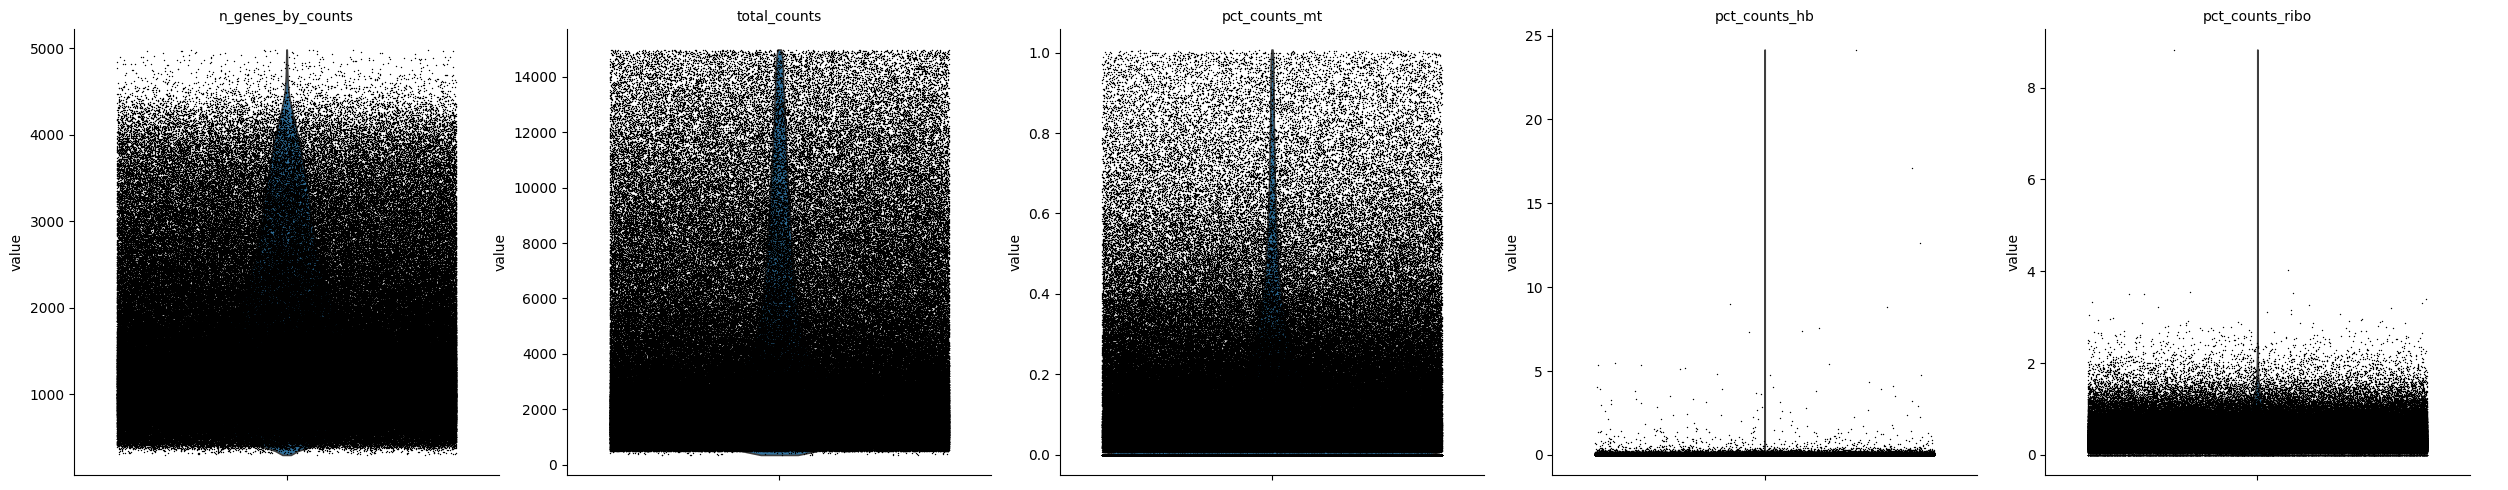

Filtered out 15 cells
CPU times: user 1min 2s, sys: 37.6 s, total: 1min 40s
Wall time: 34.4 s


/home/william/anaconda3/envs/r-kernel/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [47]:
%%time 

adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_hb", "pct_counts_ribo"], 
             jitter=0.4,multi_panel=True,)

# filter the cells out that are above the specified thresholds for mitochondrial, ribosomal, and hemoglobin reads
mito_threshold = 5.0
ribo_threshold = 5.0
hb_threshold = 5.0 

adata_size_before = adata.shape[0]

adata = ( adata[(adata.obs.pct_counts_mt <= mito_threshold) &
                (adata.obs.pct_counts_ribo <= ribo_threshold) &
                (adata.obs.pct_counts_hb <= hb_threshold), :].copy()
        )

adata_size_after = adata.shape[0]
num_filtered = adata_size_before - adata_size_after
print(f"Filtered out {num_filtered} cells")

### Note: This block will take too long to run in a jupyter notebook, so run in .py script

In [ ]:
%%time
donor_key = "donor_id"
# predict the doublets with scrublet
sc.pp.scrublet(adata, batch_key = donor_key)
num_doublets = adata[adata.obs.predicted_doublet == True].shape[0]
# filter out the doublets
adata = adata[adata.obs.predicted_doublet == False, :].copy()
print(f"Filtered out {num_doublets} likely doublets")

In [ ]:
LEIDEN_RES = 0.5
adata = preprocess_adata(adata = adata, 
                         donor_key = "donor_id",
                         leiden_resolution = LEIDEN_RES)

In [ ]:
sc.pl.umap(adata, color=["leiden", "cell_type"], size=2, legend_loc = "on data")

In [49]:
set(adata.obs.cell_type)

{'adipocyte',
 'cardiac muscle cell',
 'cardiac neuron',
 'endothelial cell',
 'fibroblast of cardiac tissue',
 'lymphocyte',
 'mast cell',
 'mural cell',
 'myeloid cell',
 'unknown'}

In [50]:
adata.obs["consistent_cell_type"] = adata.obs["cell_type"].map(
    {
        "adipocyte": "Adipocyte",
        "cardiac muscle cell": "Cardiomyocyte",
        "cardiac neuron": "Neuronal",
        "endothelial cell": "Endothelial",
        "fibroblast of cardiac tissue": "Fibroblast",
        "lymphocyte": "Lymphoid",
        "mast cell": "Mast",
        "mural cell": "Pericyte",
        "myeloid cell": "Myeloid"
    }
)

In [51]:
adata = adata[adata.obs.cell_type != 'unknown', :]

In [52]:
Counter(adata.obs.consistent_cell_type)

Counter({'Cardiomyocyte': 125509,
         'Pericyte': 84899,
         'Fibroblast': 74225,
         'Endothelial': 69285,
         'Myeloid': 35399,
         'Lymphoid': 9549,
         'Neuronal': 5103,
         'Mast': 581,
         'Adipocyte': 454})

In [22]:
Counter(adata.obs.disease)

Counter({'dilated cardiomyopathy': 451812,
         'arrhythmogenic right ventricular cardiomyopathy': 98991,
         'non-compaction cardiomyopathy': 11078})

In [24]:
adata.write("processed_Reichart_diseased.h5ad")